In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import numpy as np
from torch import nn
from PIL import Image
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import cv2
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from shutil import copyfile
import random
import time
import copy
from torch.optim import lr_scheduler

In [3]:
# 경로 설정
data_dir = './facescrub_periocular/facescrub_periocular'
train_dir = './facescrub_periocular/facescrub_periocular_train'
test_dir = './facescrub_periocular/facescrub_periocular_test'

# 데이터셋 분할 비율
train_ratio = 0.8

# 폴더 생성 함수
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

# 각 사람의 폴더 내 이미지를 train과 test로 나누어 복사
def split_data(person_dir, train_dir, test_dir, train_ratio=0.8):
    images = os.listdir(person_dir)
    random.shuffle(images)
    
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]
    person_name = os.path.basename(person_dir)
    
    # 각 사람별 train, test 폴더 생성
    train_person_dir = os.path.join(train_dir, person_name)
    test_person_dir = os.path.join(test_dir, person_name)
    
    create_folder(train_person_dir)
    create_folder(test_person_dir)
    
    # 이미지 복사
    for img in train_images:
        copyfile(os.path.join(person_dir, img), os.path.join(train_person_dir, img))
    
    for img in test_images:
        copyfile(os.path.join(person_dir, img), os.path.join(test_person_dir, img))

# 전체 데이터를 train/test로 분할
def split_dataset(data_dir, train_dir, test_dir, train_ratio=0.8):
    create_folder(train_dir)
    create_folder(test_dir)
    
    people = os.listdir(data_dir)
    
    for person in people:
        person_dir = os.path.join(data_dir, person)
        if os.path.isdir(person_dir):
            split_data(person_dir, train_dir, test_dir, train_ratio)

# 데이터셋 분할 실행
split_dataset(data_dir, train_dir, test_dir, train_ratio)

In [2]:
class FACEDATASET(Dataset):
    def __init__(self, transforms=None, split="train", testnum=10):
        self.data_dir = './facescrub_periocular/facescrub_periocular'
        self.train_dir = './facescrub_periocular/facescrub_periocular_train'
        self.test_dir = './facescrub_periocular/facescrub_periocular_test'
        self.clsname = os.listdir(self.data_dir)
        self.testnum = testnum
        self.split = split
        self.transforms = transforms
        self.sample = self.get_samples()

    def get_samples(self):
        sample = {"path": [], "name": []}
        
        if self.split == "train":
            target_dir = self.train_dir
        else:
            target_dir = self.test_dir
        
        for person in self.clsname:
            person_dir = os.path.join(target_dir, person)
            if os.path.isdir(person_dir):
                images = os.listdir(person_dir)
                for img in images:
                    sample["path"].append(os.path.join(person_dir, img))
                    sample["name"].append(person)
        
        return sample

    def name2idx(self, name):
        return self.clsname.index(name)

    def __len__(self):
        return len(self.sample["path"])
    def __getitem__(self, idx):
        img_path, label = self.sample["path"][idx], self.name2idx(self.sample["name"][idx])
        image = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.long)
        onehotlabel = F.one_hot(label, num_classes=len(self.clsname))
        
        if self.transforms is not None:
            image = self.transforms(image)

        return image, onehotlabel

In [3]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

# Split dataset into train/test
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop([50, 150], scale=(0.8, 1.2), ratio=(2.5, 3.5)),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_dataset = FACEDATASET(transforms=train_transforms, split="train", testnum=10)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = FACEDATASET(transforms=test_transforms, split="test", testnum=10)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda:1


In [5]:
# Mixup augmentation
def mixup(data, targets, alpha):
    rand_index = torch.randperm(data.size(0))
    data_a = data
    data_b = data[rand_index]
    target_a = targets
    target_b = targets[rand_index]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)])
    data = data_a * lam + data_b * (1 - lam)
    return data, target_a, target_b, lam

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, p=[0.1, 0.9]):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # History of acc and loss
    loss_hist = {"train": [], "test": []}
    acc_hist = {"train": [], "test": []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = test_dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                labels = labels.type(torch.FloatTensor)               

                optimizer.zero_grad()

                # Option selection
                option = np.random.choice(['mixup', 'naive'], p=p)

                if option == "mixup":
                    inputs, label1, label2, lam = mixup(inputs, labels, 0.5)
                    inputs = inputs.to(device)
                    label1, label2 = label1.to(device), label2.to(device)
                    lam = float(lam)                    
                else:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward
                    prediction = model(inputs)
                    _, preds = torch.max(prediction, 1)

                    if option == "naive":
                        loss = criterion(prediction, labels)
                        _, onehotlabels = torch.max(labels, 1)
                        acc = float(torch.sum(preds == onehotlabels)) / len(preds)
                    else:
                        loss = criterion(prediction, label1) * lam + criterion(prediction, label2) * (1 - lam)
                        _, onehotlabels1 = torch.max(label1, 1)
                        _, onehotlabels2 = torch.max(label2, 1)
                        acc = (lam * (preds == onehotlabels1).cpu().sum().float() +
                               (1 - lam) * (preds == onehotlabels2).cpu().sum().float()) / len(preds)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += acc * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = 100 * running_corrects / len(dataloader.dataset) 

            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}')

            # Deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_hist, acc_hist


In [7]:
# # Visualize samples
# import torch
# from torchvision.utils import make_grid
# import matplotlib.pyplot as plt

# data_iter = iter(train_dataloader)
# images, labels = next(data_iter)
# images, _, _, _ = mixup(images, labels, 1.0)

# image_grid = make_grid(images, nrow=4).numpy().transpose(1, 2, 0)

# plt.figure(figsize=(15, 5))
# plt.imshow(image_grid)
# plt.axis('off')
# plt.show()

In [8]:
# # Load pretrained ResNet18 model
# model_retrain = models.resnet18(weights=True)
# for param in model_retrain.parameters():
#     param.requires_grad = False
# for param in model_retrain.layer4[1].parameters():
#     param.requires_grad = True
# fc_in_features = model_retrain.fc.in_features

# model_retrain.fc = nn.Linear(fc_in_features, 100)

fc layer만 train

In [217]:
# Load pretrained ResNet18 model
model_ft = models.resnet18(weights=True)
# Change the pre-trained ResNet-18
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
model_ft.maxpool = nn.MaxPool2d((3, 4), (1, 3))
model_ft.avgpool = nn.AdaptiveAvgPool2d((1, 1))

# Freeze all layers except the last fully connected layer
for param in model_ft.parameters():
    param.requires_grad = False

fc_in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(fc_in_features, 100)
nn.init.xavier_uniform_(model_ft.fc.weight)

c:\Users\MILab\.conda\envs\hr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0482, -0.0756,  0.0096,  ..., -0.0329,  0.0802,  0.0608],
        [ 0.0155,  0.0094,  0.0667,  ..., -0.0429, -0.0592,  0.0395],
        [ 0.0986,  0.0556, -0.0494,  ...,  0.0341, -0.0799,  0.0450],
        ...,
        [ 0.0117, -0.0342, -0.0854,  ..., -0.0432, -0.0895,  0.0540],
        [ 0.0749,  0.0940, -0.0668,  ..., -0.0605, -0.0407, -0.0205],
        [ 0.0908, -0.0077,  0.0010,  ...,  0.0401,  0.0973,  0.0214]],
       requires_grad=True)

soft max layer만 train

In [218]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100)
model_softmax, loss_history_ft, acc_history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 4.9523 Acc: 2.52
test Loss: 4.5321 Acc: 4.84
Epoch 1/99
----------
train Loss: 4.3523 Acc: 6.57
test Loss: 4.2481 Acc: 8.54
Epoch 2/99
----------
train Loss: 3.9967 Acc: 11.95
test Loss: 4.0206 Acc: 10.42
Epoch 3/99
----------
train Loss: 3.7619 Acc: 15.83
test Loss: 3.8921 Acc: 13.92
Epoch 4/99
----------
train Loss: 3.5389 Acc: 20.09
test Loss: 3.7822 Acc: 14.47
Epoch 5/99
----------
train Loss: 3.4390 Acc: 22.52
test Loss: 3.6734 Acc: 17.08
Epoch 6/99
----------
train Loss: 3.2770 Acc: 24.66
test Loss: 3.5977 Acc: 19.34
Epoch 7/99
----------
train Loss: 3.1631 Acc: 26.08
test Loss: 3.5867 Acc: 19.75
Epoch 8/99
----------
train Loss: 3.0447 Acc: 29.65
test Loss: 3.5273 Acc: 20.17
Epoch 9/99
----------
train Loss: 3.0126 Acc: 30.77
test Loss: 3.4835 Acc: 21.77
Epoch 10/99
----------
train Loss: 2.9868 Acc: 30.63
test Loss: 3.4701 Acc: 23.13
Epoch 11/99
----------
train Loss: 2.8889 Acc: 32.42
test Loss: 3.4565 Acc: 22.59
Epoch 12/99
----------
train L

conv5만 train

In [ ]:
# Load pretrained ResNet18 model
model_ft = models.resnet18(pretrained=True)

# Modify the initial layers
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
model_ft.maxpool = nn.MaxPool2d((3, 4), (1, 3))
model_ft.avgpool = nn.AdaptiveAvgPool2d((1, 1))

# Freeze all layers except for the conv5_x block and the final fully connected layer
for name, param in model_ft.named_parameters():
    if not name.startswith('layer4'):  # layer4 corresponds to conv5_x in ResNet-18
        param.requires_grad = False

# Replace the fully connected layer
fc_in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(fc_in_features, 100)
nn.init.xavier_uniform_(model_ft.fc.weight)

conv_5만 train

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100)
model_conv5, loss_history_conv5, acc_history_conv5 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

finetune all conv layer(1e-3)

In [11]:
# Load pretrained ResNet18 model
model_ft = models.resnet18(pretrained=True)

# Modify the initial layers
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
model_ft.maxpool = nn.MaxPool2d((3, 4), (1, 3))
model_ft.avgpool = nn.AdaptiveAvgPool2d((1, 1))

# Ensure all layers are trainable
for param in model_ft.parameters():
    param.requires_grad = True

# Replace the fully connected layer
fc_in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(fc_in_features, 100)
nn.init.xavier_uniform_(model_ft.fc.weight)

c:\Users\MILab\.conda\envs\hr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MILab\.conda\envs\hr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0712, -0.0484,  0.0137,  ...,  0.0785, -0.0077, -0.0949],
        [ 0.0698, -0.0220, -0.0481,  ..., -0.0703,  0.0769,  0.0361],
        [ 0.0930, -0.0196, -0.0552,  ...,  0.0946, -0.0268, -0.0562],
        ...,
        [ 0.0866, -0.0328, -0.0385,  ...,  0.0383,  0.0663,  0.0393],
        [ 0.0442, -0.0704,  0.0025,  ...,  0.0387,  0.0091,  0.0570],
        [-0.0365, -0.0059,  0.0075,  ..., -0.0779,  0.0826,  0.0171]],
       requires_grad=True)

Fine-tune ALL convolution layers

In [12]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100)
model_ft_all, loss_history_ft_all, acc_history_ft_all = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 4.1039 Acc: 10.71
test Loss: 3.7465 Acc: 14.63
Epoch 1/99
----------
train Loss: 2.6737 Acc: 33.85
test Loss: 2.1629 Acc: 44.07
Epoch 2/99
----------
train Loss: 1.8256 Acc: 53.41
test Loss: 2.2669 Acc: 44.18
Epoch 3/99
----------
train Loss: 1.3602 Acc: 66.38
test Loss: 1.5499 Acc: 61.47
Epoch 4/99
----------
train Loss: 1.0693 Acc: 73.37
test Loss: 1.6099 Acc: 62.95
Epoch 5/99
----------
train Loss: 0.8143 Acc: 79.96
test Loss: 1.1224 Acc: 72.61
Epoch 6/99
----------
train Loss: 0.7932 Acc: 81.90
test Loss: 1.5616 Acc: 64.80
Epoch 7/99
----------
train Loss: 0.6173 Acc: 86.04
test Loss: 1.1205 Acc: 75.71
Epoch 8/99
----------
train Loss: 0.6282 Acc: 87.26
test Loss: 1.3548 Acc: 70.85
Epoch 9/99
----------
train Loss: 0.4611 Acc: 90.67
test Loss: 0.8758 Acc: 79.10
Epoch 10/99
----------
train Loss: 0.4005 Acc: 90.72
test Loss: 1.2526 Acc: 72.80
Epoch 11/99
----------
train Loss: 0.4629 Acc: 90.88
test Loss: 0.9453 Acc: 80.17
Epoch 12/99
----------
tra

Retrain from scratch

In [13]:
# Load ResNet18 model without pretrained weights
model_ft = models.resnet18(pretrained=False)

# Modify the initial layers
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
model_ft.maxpool = nn.MaxPool2d((3, 4), (1, 3))
model_ft.avgpool = nn.AdaptiveAvgPool2d((1, 1))

# Ensure all layers are trainable (by default, this will be the case)
for param in model_ft.parameters():
    param.requires_grad = True

# Replace the fully connected layer
fc_in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(fc_in_features, 100)
nn.init.xavier_uniform_(model_ft.fc.weight)

# Initialize weights for convolutional layers (optional but recommended for training from scratch)
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model_ft.apply(initialize_weights)

c:\Users\MILab\.conda\envs\hr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(3, 4), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

Retrain the whole model from scratch.

In [14]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
# model_ft = torch.nn.DataParallel(model_ft, output_device=1).to(device)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=5e-3)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100)
model_rt, loss_history_rt, acc_history_rt = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 5.0417 Acc: 1.77
test Loss: 4.7008 Acc: 2.20
Epoch 1/99
----------
train Loss: 4.4987 Acc: 2.32
test Loss: 4.5612 Acc: 3.40
Epoch 2/99
----------
train Loss: 4.2618 Acc: 4.50
test Loss: 4.2295 Acc: 4.76
Epoch 3/99
----------
train Loss: 4.0279 Acc: 6.26
test Loss: 3.8937 Acc: 6.97
Epoch 4/99
----------
train Loss: 3.7884 Acc: 9.68
test Loss: 3.6951 Acc: 12.41
Epoch 5/99
----------
train Loss: 3.5351 Acc: 13.97
test Loss: 3.7337 Acc: 11.66
Epoch 6/99
----------
train Loss: 3.3034 Acc: 17.84
test Loss: 3.3730 Acc: 18.70
Epoch 7/99
----------
train Loss: 3.0109 Acc: 23.87
test Loss: 3.1894 Acc: 23.78
Epoch 8/99
----------
train Loss: 2.7594 Acc: 29.54
test Loss: 3.3308 Acc: 22.19
Epoch 9/99
----------
train Loss: 2.5155 Acc: 36.54
test Loss: 2.5729 Acc: 36.30
Epoch 10/99
----------
train Loss: 2.1892 Acc: 45.27
test Loss: 2.5257 Acc: 39.18
Epoch 11/99
----------
train Loss: 1.8521 Acc: 52.81
test Loss: 2.2023 Acc: 45.02
Epoch 12/99
----------
train Loss: 

Training complete in 17m 32s 96.09 Best val Acc: 85.145653 with lr 1e-2
Training complete in  Best val Acc: 87.29  with lr 5e-3
Training complete in  Best val Acc: 84.56 with lr 1e-3
Training complete in  Best val Acc:   with lr 1e-4


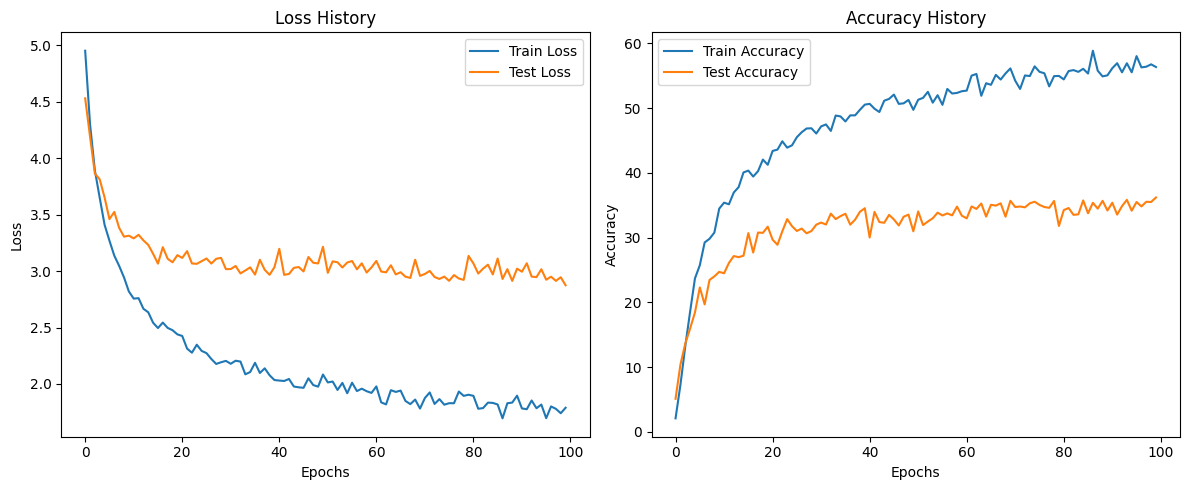

In [163]:
import matplotlib.pyplot as plt

# Assuming loss_hist and acc_hist are obtained from the training function
# loss_hist = {'train': [...], 'test': [...]}
# acc_hist = {'train': [...], 'test': [...]}

def plot_training_history(loss_hist, acc_hist):
    epochs = range(len(loss_hist['train']))

    plt.figure(figsize=(12, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_hist['train'], label='Train Loss')
    plt.plot(epochs, loss_hist['test'], label='Test Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_hist['train'], label='Train Accuracy')
    plt.plot(epochs, acc_hist['test'], label='Test Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with your loss_hist and acc_hist
plot_training_history(loss_history_ft, acc_history_ft)
# plot_training_history(loss_history_conv5, acc_history_conv5)
# plot_training_history(loss_history_ft_all, acc_history_ft_all)
# plot_training_history(loss_history_rt, acc_history_rt)


In [ ]:
def visualize_model(model, test_dataloader, num_images=6):
    was_training = model.training
    clsname = os.listdir('./facescrub_periocular/facescrub_periocular')
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {clsname[preds[j]]}')
                
                # Convert from (C, H, W) to (H, W, C)
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                # Reverse the normalization (assuming images were normalized)
                img = img * 0.5 + 0.5  # assuming the normalization was done using mean=0.5, std=0.5
                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft,test_dataloader)
visualize_model(model_conv5,test_dataloader)
visualize_model(model_ft_all,test_dataloader)
visualize_model(model_rt,test_dataloader)

In [216]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Tensor is on device: cuda:1
Model is on device: cuda:1


100%|██████████| 32/32 [00:00<00:00, 45.75it/s]


Original image size: (261, 289)
Resized image shape: (50, 150, 3)
Image tensor shape: torch.Size([1, 3, 50, 150])
Grayscale CAM shape: (1, 50, 150)


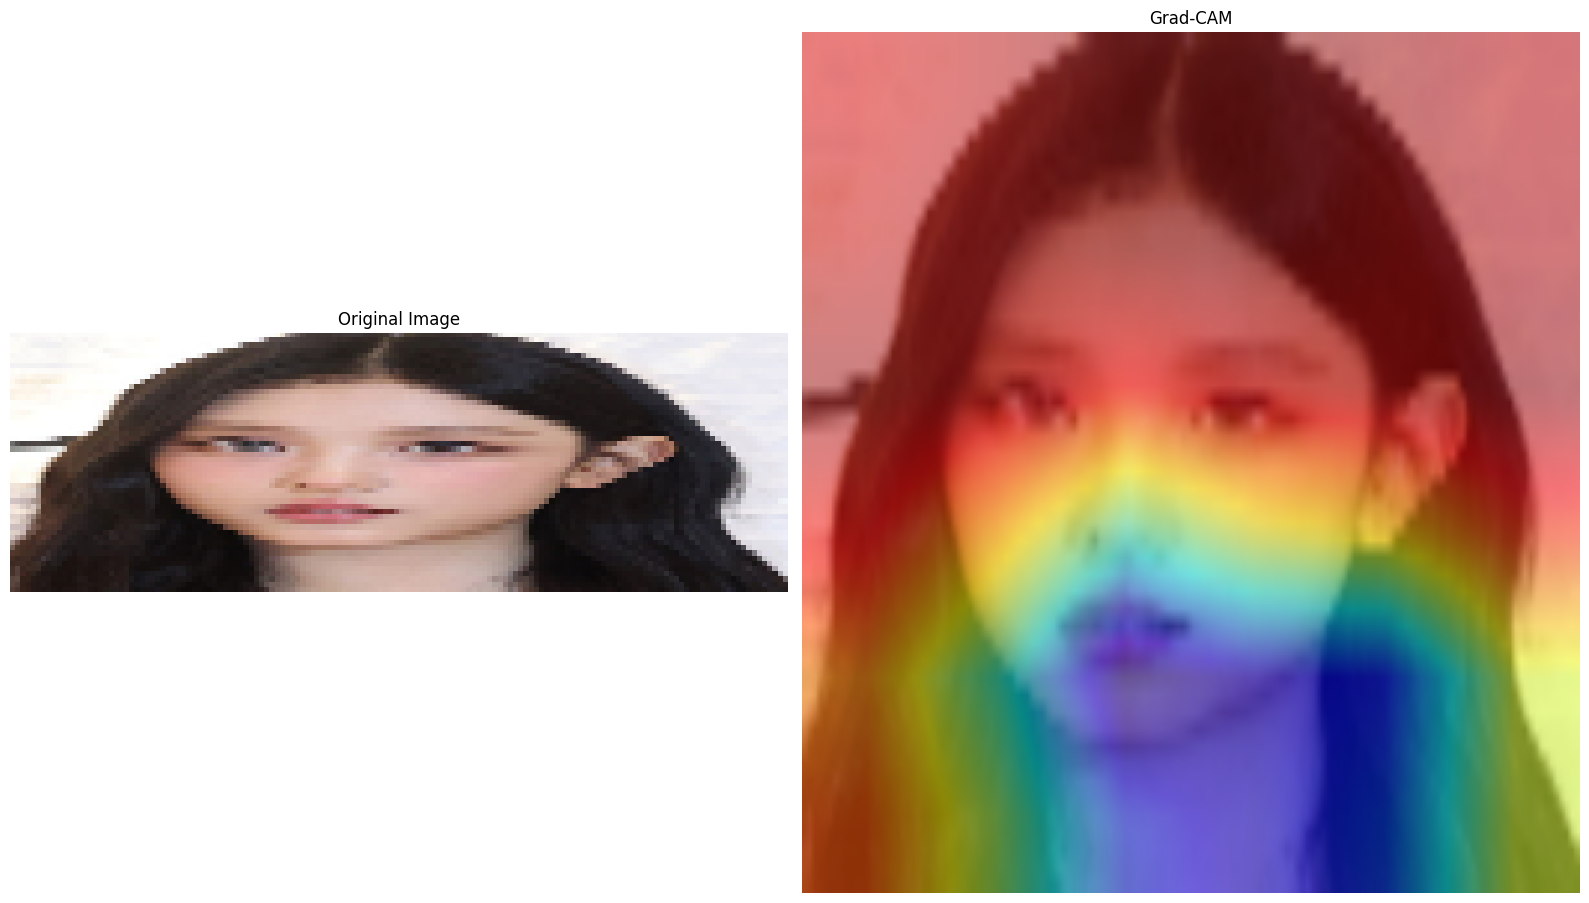

In [255]:
from pytorch_grad_cam import GradCAM, AblationCAM,LayerCAM,ScoreCAM
# Define image size
img_size = (50, 150)

model = model_softmax #baseline
# model = model_ft_all # finetune all
# model = model_rt # retrain all
# Set the model to evaluation mode
model.eval()

# Load image
# image = Image.open("./human1.png").convert('RGB')
image = Image.open("./human2.png").convert('RGB')
# image = Image.open("./human1-1.png").convert('RGB')  # Ensure the image is in RGB mode
# image = Image.open("./human2-2.png").convert('RGB')
original_size = image.size 
image = cv2.resize(np.array(image), (img_size[1], img_size[0]))
dataset = FACEDATASET(split=None)

# Define transforms
test_transforms = T.Compose([
    transforms.ToTensor(),
    normalize
])

# Apply transforms to the image
image_tensor = test_transforms(image)

# Plotting the results
fig = plt.figure(tight_layout=True, figsize=(16,16))
rows = 1
cols = 2

# Original image
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(np.array(image))
ax1.set_title("Original Image")
ax1.axis("off")

# Prepare image tensor
image_tensor = image_tensor.unsqueeze(0).to(device)
# model.to(device)
# Check devices
print(f"Tensor is on device: {image_tensor.device}")
print(f"Model is on device: {next(model.parameters()).device}")

# Grad-CAM
gradcam = ScoreCAM(model=model, target_layers=[model.layer4[-1]])
# gradcam = GradCAM(model=model, target_layers=[model.layer4[-1]])
grayscale_cam = gradcam(input_tensor=image_tensor)

# # Reverse the colormap
# grayscale_cam = 1 - grayscale_cam

# Debugging: Print shapes
print(f"Original image size: {original_size}")
print(f"Resized image shape: {np.array(image).shape}")
print(f"Image tensor shape: {image_tensor.shape}")
print(f"Grayscale CAM shape: {grayscale_cam.shape}")

# Ensure the image and the CAM have the same size
resized_image = cv2.resize(np.array(image), (img_size[1], img_size[0]))
visualization2 = show_cam_on_image(resized_image/255.0,grayscale_cam[0,:])

# Resize back to the original image size
visualization2 = cv2.resize(visualization2, original_size)

# Display Grad-CAM
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(visualization2)
ax2.set_title("Grad-CAM")
ax2.axis("off")

plt.show()

In [222]:
len(grayscale_cam[0,:])

162